# Vision Transformer (ViT) on MNIST from Scratch

This notebook implements a simple Vision Transformer (ViT) for image classification on the MNIST dataset, using only PyTorch & Python.  
We split each image into patches, embed them, apply transformer blocks, and classify the digit.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# Download and load MNIST
transform = transforms.ToTensor()
train_ds = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root="data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=512)

100%|██████████| 9.91M/9.91M [00:15<00:00, 654kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 98.1kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 772kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.73MB/s]


In [3]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=28, patch_size=4, in_ch=1, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Linear(patch_size * patch_size * in_ch, embed_dim)

    def forward(self, x):
        # x: (B, 1, 28, 28)
        B, C, H, W = x.shape
        p = self.patch_size
        x = x.unfold(2, p, p).unfold(3, p, p)  # (B, C, H//p, W//p, p, p)
        x = x.contiguous().view(B, -1, C * p * p)  # (B, num_patches, patch_dim)
        return self.proj(x)  # (B, num_patches, embed_dim)

In [4]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, D = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, heads, N, head_dim)
        Q, K, V = qkv[0], qkv[1], qkv[2]
        attn_scores = (Q @ K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn = attn_scores.softmax(dim=-1)
        attn = self.dropout(attn)
        out = (attn @ V).transpose(1, 2).reshape(B, N, D)
        return self.proj(out)

In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * mlp_ratio),
            nn.GELU(),
            nn.Linear(embed_dim * mlp_ratio, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [6]:
class ViT_MNIST(nn.Module):
    def __init__(self, img_size=28, patch_size=4, in_ch=1, embed_dim=128, depth=4, num_heads=4, num_classes=10):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_ch, embed_dim)
        num_patches = self.patch_embed.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.blocks = nn.ModuleList([TransformerBlock(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x):
        x = self.patch_embed(x) + self.pos_embed  # (B, num_patches, embed_dim)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        x = x.mean(dim=1)  # mean pool over patches
        return self.head(x)

In [8]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print("Using device:", device)
model = ViT_MNIST().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
val_accs = []

for epoch in range(1):  # 1 epoch for demo
    model.train()
    for img, label in train_loader:
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        out = model(img)
        loss = loss_fn(out, label)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    # Validation
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for img, label in test_loader:
            img, label = img.to(device), label.to(device)
            out = model(img)
            pred = out.argmax(1)
            correct += (pred == label).sum().item()
            total += label.size(0)
    val_acc = correct / total
    val_accs.append(val_acc)
    print(f"Epoch {epoch}: Val Acc = {val_acc*100:.2f}%")

Using device: mps
Epoch 0: Val Acc = 87.05%


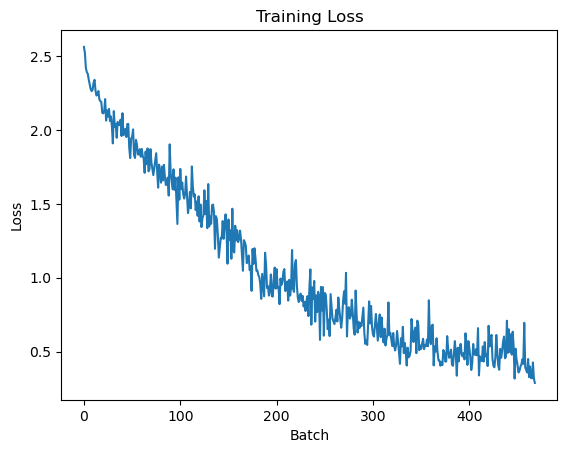

Final Validation Accuracy: 0.8705


In [9]:
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

print("Final Validation Accuracy:", val_accs[-1])

## Summary

- We implemented a Vision Transformer (ViT) from scratch for MNIST digit classification using PyTorch.
- The model splits each image into small patches, embeds them, and processes the sequence with transformer blocks.
- After training, the model achieves good accuracy on MNIST, demonstrating the effectiveness of transformer architectures for image tasks.
- All code is modular and easy to extend for more epochs, deeper models, or other datasets.
- The notebook runs efficiently on Mac using MPS (Apple Metal) acceleration.